# Haomin Wang

# DSC 478 Final Project

# Predicting LendingClub Loan Charge-offs from Initial Listing Data


**June 09, 2019**

## Table of Contents

* [1. Introduction](#1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 Random forest classifier](#8.2)
 * [8.3 k-nearest neighbors](#8.3)
 * [8.4 Tune hyperparameters on the chosen model more finely](#8.4)
 * [8.5 Test set evaluation](#8.5)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

The dataset is from Kaggle: https://www.kaggle.com/wendykan/lending-club-loan-data

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.


# 2. Import the Data
<a id="2"></a>

In [1]:
cd /Users/micha/Desktop/478

C:\Users\micha\Desktop\478


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe:

In [3]:
#loans = pd.read_csv('../input/accepted_2007_to_2018Q2.csv.gz', compression='gzip', low_memory=True)
loans = pd.read_csv('loan.csv', low_memory=True)

C:\Users\micha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info:

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


There are 2.2 million rows and 144 variables. The size of the dataset is 2.4 GB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [5]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
32182,NaN,NaN,3000,3000,3000.0,36 months,17.97,108.42,D,D1,Speech and Language Pathologist,2 years,RENT,73000.0,Verified,Dec-2018,Current,n,NaN,NaN,medical,Medical expenses,104xx,NY,24.76,0.0,Sep-2007,0.0,NaN,NaN,12.0,0.0,12552,93.0,19.0,w,2806.64,2806.64,310.480000,310.48,193.36,117.12,0.0,0.00,0.0000,Feb-2019,108.42,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,193481.0,0.0,9.0,0.0,1.0,19.0,180929.0,112.0,0.0,0.0,5387.0,110.0,13500.0,0.0,0.0,0.0,1.0,16123.0,317.0,96.8,0.0,0.0,135.0,111.0,29.0,19.0,0.0,29.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,13.0,3.0,6.0,3.0,12.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,173016.0,193481.0,9900.0,159516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
975922,NaN,NaN,5000,5000,5000.0,36 months,5.32,150.58,A,A1,Production Coordinator,< 1 year,RENT,30000.0,Not Verified,Nov-2015,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,926xx,CA,24.16,0.0,Jan-2010,0.0,NaN,NaN,7.0,0.0,5960,29.5,8.0,w,0.00,0.00,5393.138836,5393.14,5000.00,393.14,0.0,0.00,0.0000,Feb-2018,1479.54,NaN,Mar-2018,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,29828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200.0,NaN,NaN,NaN,3.0,4261.0,11601.0,18.3,0.0,0.0,51.0,70.0,2.0,2.0,0.0,2.0,NaN,NaN,NaN,0.0,2.0,3.0,3.0,3.0,2.0,5.0,6.0,3.0,7.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,50231.0,29828.0,14200.0,30031.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1171428,NaN,NaN,15000,15000,15000.0,60 months,12.29,335.87,C,C1,Detective,10+ years,MORTGAGE,108000.0,Verified,Jul-2015,Fully Paid,n,NaN,NaN,debt_consol

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [6]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [7]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [8]:
loans.shape

(1303607, 145)

 Check that the statuses are as expected:

In [9]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     1041952
Charged Off     261655
Name: loan_status, dtype: int64

Status counts as percentages:

In [10]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.799284
Charged Off    0.200716
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 20% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.



## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [11]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [12]:
missing_fractions.head(10)

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.997367
hardship_length                               0.995908
hardship_type                                 0.995908
hardship_reason                               0.995908
hardship_status                               0.995908
deferral_term                                 0.995908
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

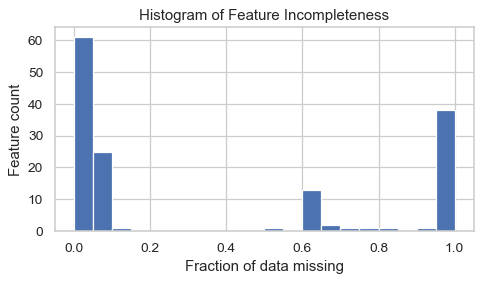

In [13]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [14]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_o

How many features will be dropped?

In [15]:
len(drop_list)

58

Drop these features:

In [16]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [17]:
loans.shape

(1303607, 87)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [18]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [19]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [20]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [21]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex

In [22]:
len(drop_list)

59

Drop these features:

In [23]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [24]:
loans.shape

(1303607, 28)

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [25]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [26]:
print(list(loans.columns))

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 loan_amnt

In [27]:
loans['loan_amnt'].describe()

count    1.303607e+06
mean     1.441681e+04
std      8.699542e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$14,000.

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


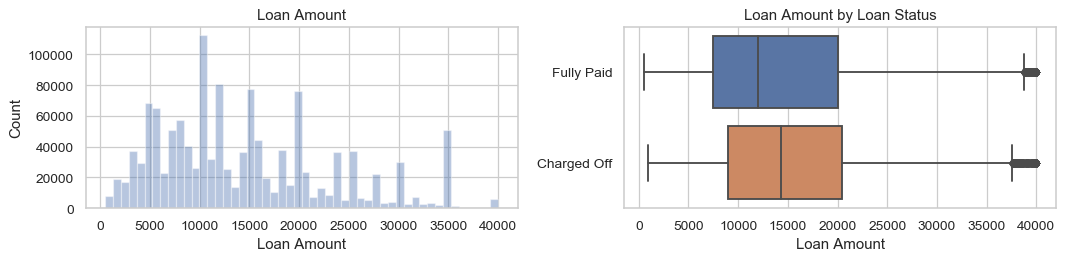

In [28]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [29]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,15548.979381,8797.539356,900.0,9000.0,14350.0,20400.0,40000.0
Fully Paid,1041952.0,14132.493699,8651.520017,500.0,7500.0,12000.0,20000.0,40000.0


## 5.2 term

In [30]:
loans['term'].value_counts(dropna=False)

 36 months    988754
 60 months    314853
Name: term, dtype: int64

Convert `term` to integers.

In [31]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [32]:
loans['term'].value_counts(normalize=True)

36    0.758476
60    0.241524
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [33]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.160959
60    0.325568
Name: loan_status, dtype: float64

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.3 int_rate

In [34]:
loans['int_rate'].describe()

count    1.303607e+06
mean     1.325722e+01
std      4.760544e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

Interest rates range from 5.31% to 30.99% (!) with a median of 13.2%.

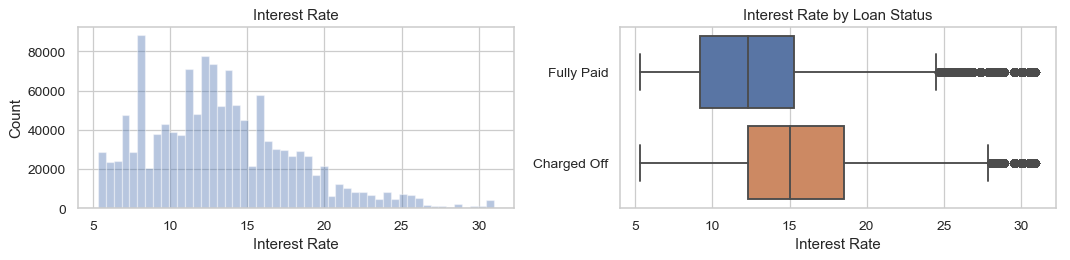

In [35]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [36]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,15.712087,4.897685,5.31,12.29,15.05,18.55,30.99
Fully Paid,1041952.0,12.640755,4.520709,5.31,9.17,12.29,15.31,30.99


## 5.4 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [37]:
loans['installment'].describe()

count    1.303607e+06
mean     4.380850e+02
std      2.610632e+02
min      4.930000e+00
25%      2.488200e+02
50%      3.754300e+02
75%      5.804500e+02
max      1.719830e+03
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

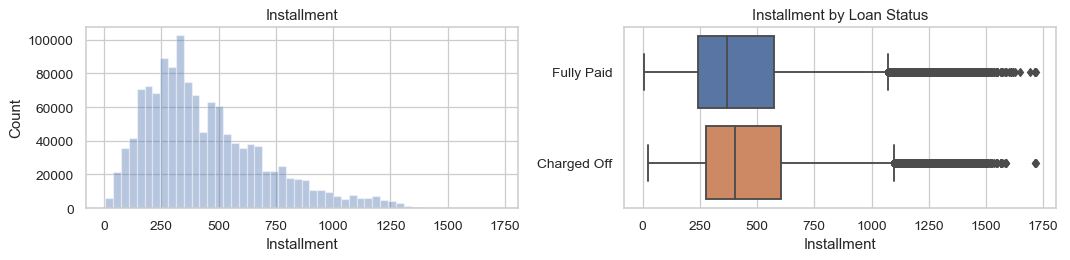

In [38]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [39]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,464.749514,262.341293,21.62,275.22,402.83,604.145,1717.63
Fully Paid,1041952.0,431.388962,260.312645,4.93,241.12,368.63,573.060,1719.83


Loans that charge off have \$33 higher installments on average.

## 5.5 grade, sub_grade

In [40]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [41]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [42]:
loans.drop('grade', axis=1, inplace=True)

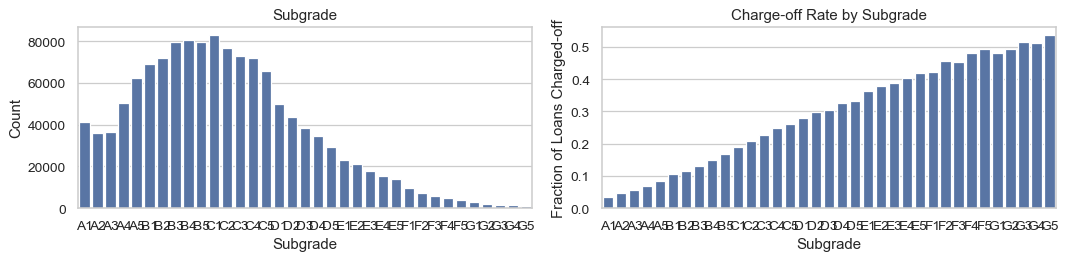

In [43]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.6 emp_title

In [44]:
loans['emp_title'].describe()

count     1221028
unique     371435
top       Teacher
freq        20496
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [45]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.7 emp_length

In [46]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        85677
10+ years    428547
2 years      117820
3 years      104200
4 years       78029
5 years       81623
6 years       60933
7 years       58145
8 years       59125
9 years       49504
< 1 year     104550
NaN           75454
Name: emp_length, dtype: int64

Note there are 75,454 loans without data on the length of employment.

Convert `emp_length` to integers:

In [47]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [48]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [49]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [50]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [51]:
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0     104550
 1.0      85677
 2.0     117820
 3.0     104200
 4.0      78029
 5.0      81623
 6.0      60933
 7.0      58145
 8.0      59125
 9.0      49504
 10.0    428547
NaN       75454
Name: emp_length, dtype: int64

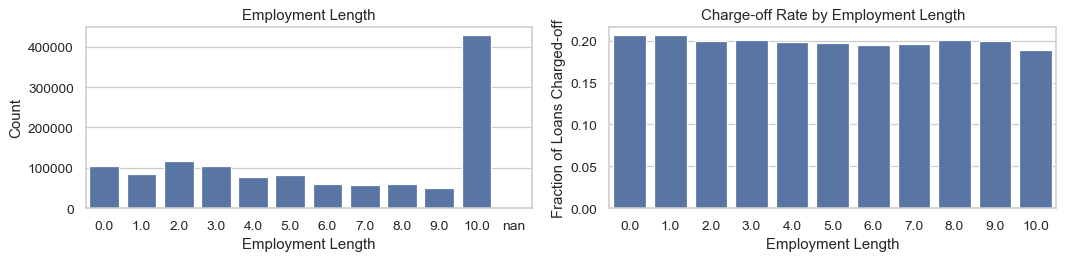

In [52]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.8 home_ownership

In [53]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    645496
RENT        517808
OWN         139844
ANY            267
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [54]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [55]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    645496
RENT        517808
OWN         139844
OTHER          459
Name: home_ownership, dtype: int64

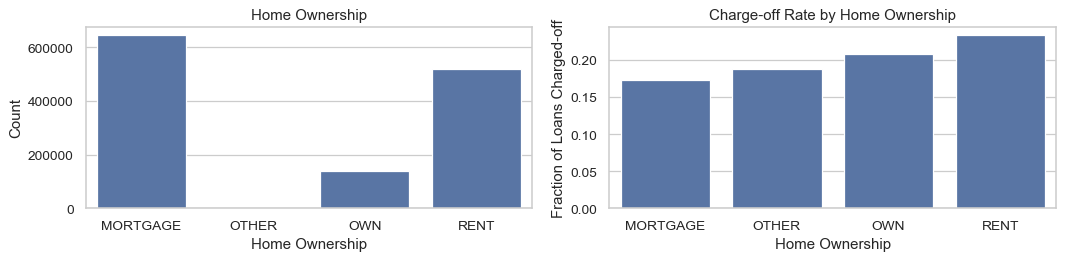

In [56]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [57]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.172986
OTHER       0.187364
OWN         0.207453
RENT        0.233477
Name: loan_status, dtype: float64

## 5.9 annual_inc

In [58]:
loans['annual_inc'].describe()

count    1.303607e+06
mean     7.615899e+04
std      7.004890e+04
min      0.000000e+00
25%      4.584000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$10,990,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [59]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [60]:
loans.drop('annual_inc', axis=1, inplace=True)

In [61]:
loans['log_annual_inc'].describe()

count    1.303607e+06
mean     4.812791e+00
std      2.453588e-01
min      0.000000e+00
25%      4.661254e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

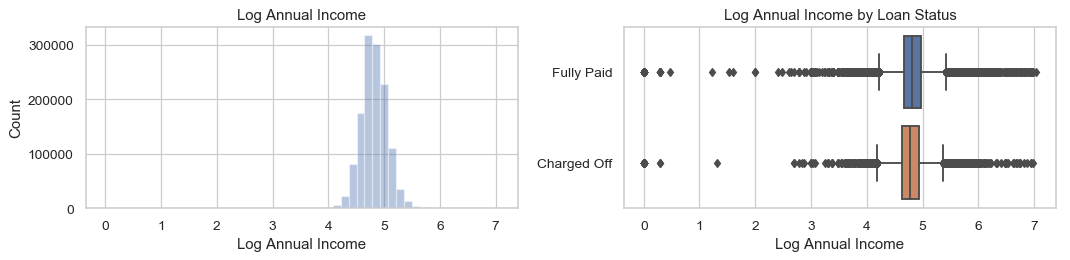

In [62]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [63]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,4.781632,0.240262,0.0,4.633479,4.778158,4.929424,6.977724
Fully Paid,1041952.0,4.820615,0.246003,0.0,4.672107,4.812920,4.968488,7.041361


## 5.10 verification_status

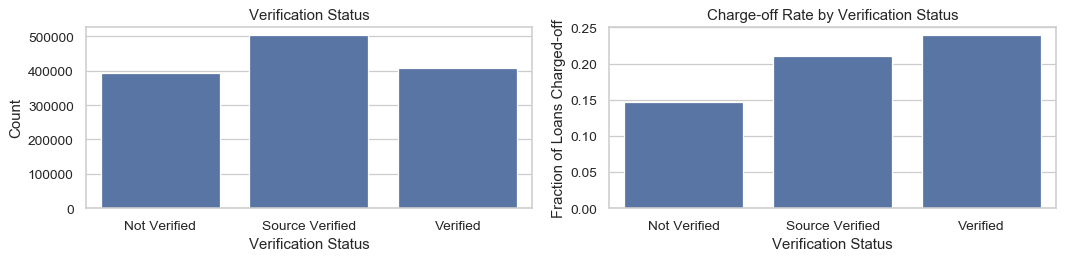

In [64]:
plot_var('verification_status', 'Verification Status', continuous=False)

## 5.11 purpose

In [65]:
loans['purpose'].value_counts()

debt_consolidation    757591
credit_card           285704
home_improvement       84495
other                  74934
major_purchase         28328
medical                15023
small_business         15010
car                    14120
moving                  9172
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [66]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121622
car                   0.146388
credit_card           0.170267
educational           0.171779
home_improvement      0.178531
major_purchase        0.187235
vacation              0.192396
other                 0.211706
debt_consolidation    0.212567
house                 0.217167
medical               0.219064
moving                0.234409
renewable_energy      0.237102
small_business        0.297468
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

## 5.12 title

Data Dictionary: "The loan title provided by the borrower."

In [67]:
loans['title'].describe()

count                1288181
unique                 61678
top       Debt consolidation
freq                  638945
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [68]:
loans['title'].value_counts().head(10)

Debt consolidation         638945
Credit card refinancing    240679
Home improvement            72125
Other                       63875
Major purchase              22974
Debt Consolidation          15692
Medical expenses            13060
Business                    11359
Car financing               10768
Vacation                     7721
Name: title, dtype: int64

 The `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [69]:
loans.drop('title', axis=1, inplace=True)

## 5.13 zip_code, addr_state

In [70]:
loans['zip_code'].sample(5)

2229674    319xx
1291674    371xx
1137576    064xx
586023     870xx
1125940    551xx
Name: zip_code, dtype: object

In [71]:
loans['zip_code'].nunique()

943

In [72]:
loans['addr_state'].sample(5)

1924258    KY
634752     FL
2064958    VA
1111283    MN
1805597    CA
Name: addr_state, dtype: object

In [73]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [74]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [75]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.131157
ME    0.139063
VT    0.141071
IA    0.142857
OR    0.144003
NH    0.145923
CO    0.155936
WV    0.158483
WA    0.158880
SC    0.164761
KS    0.167646
WY    0.169665
MT    0.169776
UT    0.171794
CT    0.174894
RI    0.180077
IL    0.182302
WI    0.183171
GA    0.184221
MA    0.191122
ID    0.193320
AZ    0.196778
CA    0.197103
TX    0.199123
AK    0.199225
MN    0.199389
VA    0.200233
DE    0.202128
HI    0.202954
MI    0.203645
OH    0.208078
ND    0.208471
PA    0.208808
NC    0.209422
KY    0.210886
NJ    0.212716
MD    0.213421
SD    0.213513
MO    0.214171
NM    0.215423
FL    0.215615
TN    0.215956
IN    0.216053
NV    0.220537
NY    0.221452
LA    0.234072
OK    0.237126
AL    0.237336
AR    0.241656
NE    0.254237
MS    0.262033
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington.

## 5.14 dti

In [76]:
loans['dti'].describe()

count    1.303295e+06
mean     1.825875e+01
std      1.093849e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.404000e+01
max      9.990000e+02
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

Text(0.5, 1.0, 'Debt-to-income Ratio')

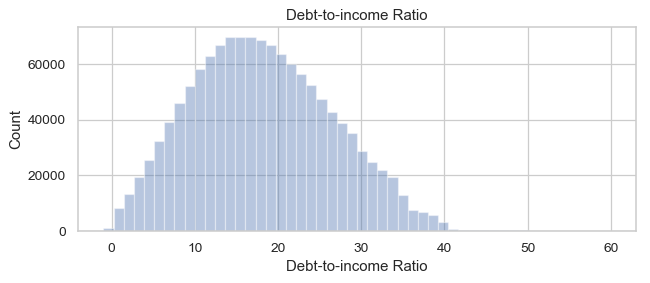

In [77]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [78]:
(loans['dti']>=60).sum()

1540

Very few. Compare the summary statistics by loan status:

In [79]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261593.0,20.161590,11.292371,0.0,13.58,19.77,26.31,999.0
Fully Paid,1041702.0,17.780909,10.795249,-1.0,11.42,17.09,23.41,999.0


Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.15 earliest_cr_line

In [80]:
loans['earliest_cr_line'].sample(5)

959294     Oct-2006
2135025    Oct-1998
1342880    Mar-2000
1841260    Feb-1982
638567     Nov-1981
Name: earliest_cr_line, dtype: object

In [81]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [82]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [83]:
loans['earliest_cr_line'].describe()

count    1.303607e+06
mean     1.998651e+03
std      7.590199e+00
min      1.934000e+03
25%      1.995000e+03
50%      2.000000e+03
75%      2.004000e+03
max      2.015000e+03
Name: earliest_cr_line, dtype: float64

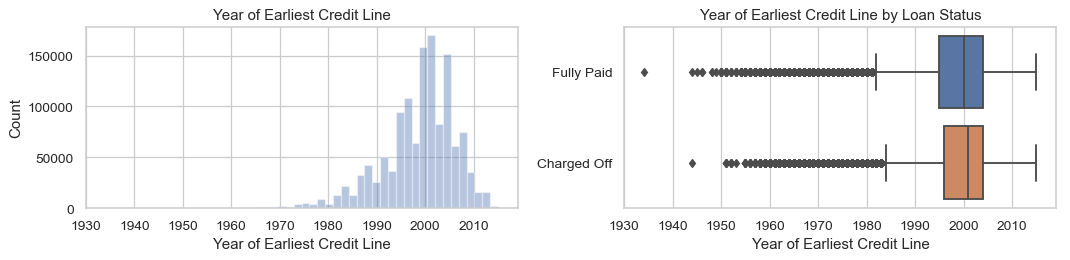

In [84]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.16 open_acc

Text(0.5, 1.0, 'Number of Open Credit Lines')

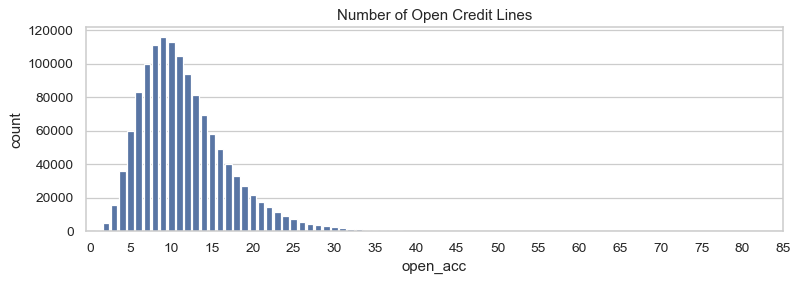

In [85]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [86]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,11.906472,5.630599,0.0,8.0,11.0,15.0,76.0
Fully Paid,1041952.0,11.513452,5.420120,0.0,8.0,11.0,14.0,90.0


## 5.17 pub_rec

In [87]:
loans['pub_rec'].value_counts().sort_index()

0.0     1082511
1.0      185104
2.0       23744
3.0        7166
4.0        2533
5.0        1224
6.0         616
7.0         274
8.0         155
9.0          80
10.0         56
11.0         37
12.0         27
13.0         18
14.0          5
15.0          9
16.0          5
17.0          3
18.0          6
19.0          5
20.0          3
21.0          6
22.0          2
23.0          1
24.0          2
25.0          1
28.0          3
34.0          1
37.0          1
40.0          1
46.0          1
47.0          1
49.0          2
54.0          1
61.0          1
63.0          1
86.0          1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [88]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,0.247203,0.658632,0.0,0.0,0.0,0.0,86.0
Fully Paid,1041952.0,0.207566,0.587759,0.0,0.0,0.0,0.0,63.0


## 5.18 revol_bal

In [89]:
loans['revol_bal'].describe()

count    1.303607e+06
mean     1.623599e+04
std      2.228629e+04
min      0.000000e+00
25%      5.952000e+03
50%      1.114000e+04
75%      1.974800e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [90]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [91]:
loans.drop('revol_bal', axis=1, inplace=True)

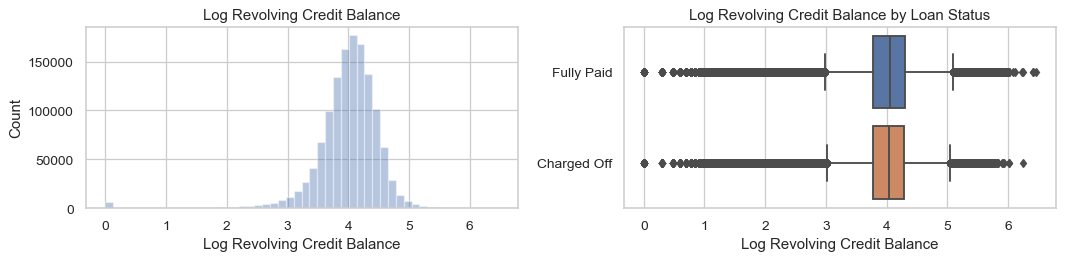

In [92]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [93]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,3.987228,0.512545,0.0,3.778585,4.044853,4.281738,6.242223
Fully Paid,1041952.0,3.994177,0.534899,0.0,3.773786,4.047431,4.299115,6.463122


There isn't a large difference in the means.

## 5.19 revol_util

In [94]:
loans['revol_util'].describe()

count    1.302797e+06
mean     5.191014e+01
std      2.450155e+01
min      0.000000e+00
25%      3.360000e+01
50%      5.230000e+01
75%      7.080000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

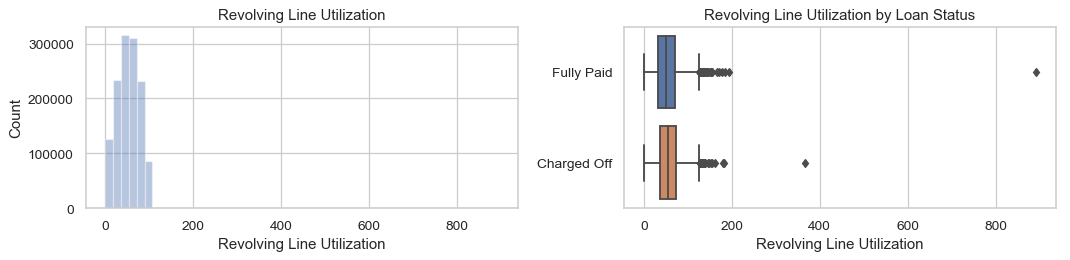

In [95]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [96]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261487.0,54.896443,23.828058,0.0,37.6,55.7,73.2,366.6
Fully Paid,1041310.0,51.160233,24.610939,0.0,32.6,51.4,70.1,892.3


## 5.20 total_acc

Text(0.5, 1.0, 'Total Number of Credit Lines')

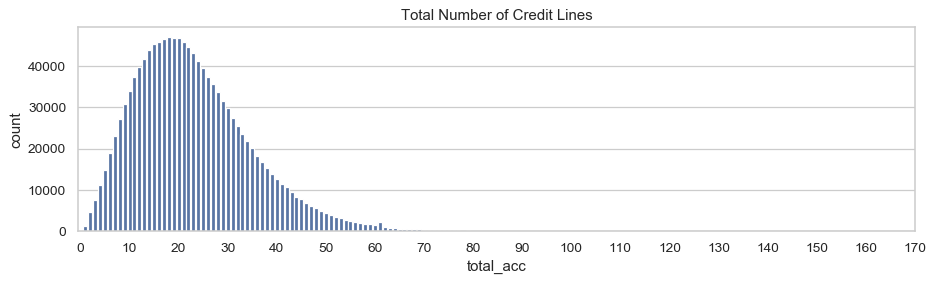

In [97]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [98]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,24.747675,12.114216,2.0,16.0,23.0,32.0,176.0
Fully Paid,1041952.0,25.087058,11.964972,2.0,16.0,23.0,32.0,162.0


No large differences here.

## 5.21 initial_list_status

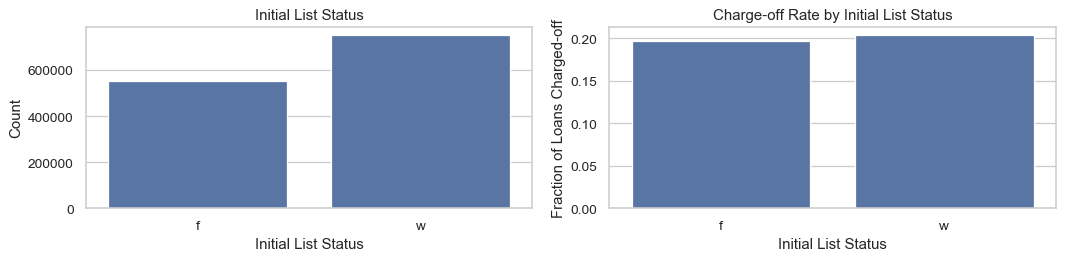

In [99]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.22 application_type

In [100]:
loans['application_type'].value_counts()

Individual    1280370
Joint App       23237
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [101]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.199884
Joint App     0.246546
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## 5.23 mort_acc

In [102]:
loans['mort_acc'].describe()

count    1.256326e+06
mean     1.676875e+00
std      2.005056e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [103]:
loans['mort_acc'].value_counts().head(10)

0.0    505844
1.0    218700
2.0    182697
3.0    135109
4.0     92202
5.0     56126
6.0     31755
7.0     16487
8.0      8202
9.0      4190
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [104]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,254769.0,1.375371,1.829391,0.0,0.0,1.0,2.0,29.0
Fully Paid,1001557.0,1.753570,2.040241,0.0,0.0,1.0,3.0,51.0


Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.24 pub_rec_bankruptcies

In [105]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     1140180
1.0      153011
2.0        7590
3.0        1539
4.0         381
5.0         136
6.0          45
7.0          15
8.0           9
9.0           2
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

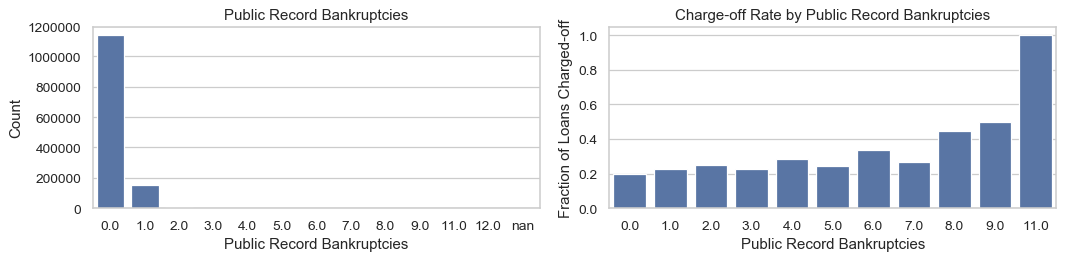

In [106]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [107]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [108]:
loans.shape

(1303607, 24)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [109]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [110]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

emp_length              0.057881
mort_acc                0.036269
revol_util              0.000621
pub_rec_bankruptcies    0.000535
dti                     0.000239
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [111]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [112]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [113]:
loans.shape

(1303607, 121)

Check our data with the new dummy variables:

In [114]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1031012,35000,60,17.57,880.61,9.0,Oct-2015,28.06,1996,17.0,0.0,34.5,24.0,2.0,0.0,5.000004,4.377015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1160085,16000,60,13.33,366.76,10.0,Jul-2015,19.86,2002,11.0,0.0,91.0,22.0,3.0,0.0,4.903095,4.514016,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2034886,13200,36,14.64,455.26,8.0,Apr-2014,26.43,1999,10.0,2.0,71.9,22.0,2.0,0.0,4.690205,3.932271,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
558899,12000,60,14.49,282.28,10.0,Aug-2016,18.52,1999,12.0,1.0,93.7,26.0,0.0,1.0,4.477136,4.130044,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2041283,10000,36,12.49,334.49,10.0,Apr-2014,14.80,1996,9.0,0.0,28.0,21.0,1.0,0.0,4.623260,3.864096,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [115]:
loans['issue_d'].sample(5)

1491497    Aug-2017
1083222    Sep-2015
1287831    Mar-2015
891593     Nov-2016
1280937    Mar-2015
Name: issue_d, dtype: object

Are there any missing values?

In [116]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [117]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [118]:
loans['issue_d'].sample(5)

953270    2015-12-01
501602    2016-09-01
963335    2015-12-01
1063150   2015-09-01
1700044   2013-11-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [119]:
loans['issue_d'].describe()

count                 1303607
unique                    139
top       2015-10-01 00:00:00
freq                    42727
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

There are only 139 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in December 2018. The busiest month was October 2015 with 42,727 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5, 1.0, 'Loans Funded per Year')

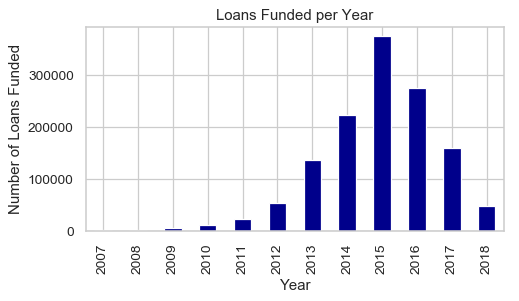

In [120]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [121]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [122]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    1303607
Number of loans in the full dataset: 1303607


What is the test size?

In [123]:
loans_test.shape[0] / loans.shape[0]

0.10254010602888754

The partition looks good, so we can delete the original `loans` dataframe:

In [124]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [125]:
loans_train['issue_d'].describe()

count                 1169935
unique                    120
top       2015-10-01 00:00:00
freq                    42727
first     2007-06-01 00:00:00
last      2017-05-01 00:00:00
Name: issue_d, dtype: object

In [126]:
loans_test['issue_d'].describe()

count                  133672
unique                     19
top       2017-08-01 00:00:00
freq                    14449
first     2017-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to June 2017. The test set includes loans from July 2017 to December 2018.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [127]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:
Because the input dataset is really big,  I only take 10% DATA for training.  You can use 100% data. 

In [128]:
subsetloans_train=loans_train.sample(frac=0.1)

#y_train = loans_train['charged_off']
y_train = subsetloans_train['charged_off']

y_test = loans_test['charged_off']

In [129]:
#X_train = loans_train.drop('charged_off', axis=1)
X_train = subsetloans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [130]:
del loans_train, loans_test

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, F-statistics and $p$ value of each predictor with the response variable `charged_off`.

In [131]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [132]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

$F$-statistics:

In [133]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Sort the results by the absolute value of the Pearson correlation:

In [134]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [135]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [136]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.263027,8695.444568,0.000000e+00
1,term,0.176324,3753.996464,0.000000e+00
2,dti,0.099492,1169.570482,4.590338e-255
3,sub_grade_A4,-0.069858,573.729807,1.752002e-126
4,mort_acc,-0.068733,533.174017,1.084843e-117
5,sub_grade_A5,-0.064489,488.584399,4.826791e-108
6,loan_amnt,0.062382,457.047817,3.300240e-101
7,log_annual_inc,-0.062188,454.200425,1.367087e-100
8,sub_grade_E5,0.062079,452.614188,3.017635e-100
9,sub_grade_A2,-0.061832,449.001588,1.831671e-99


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [137]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
99,addr_state_RI,-0.002959,1.024443,0.311470
100,addr_state_TX,-0.002791,0.911366,0.339754
101,addr_state_AR,0.002465,0.711082,0.399087
102,total_acc,-0.002311,0.624917,0.429228
103,addr_state_NM,0.002013,0.474149,0.491086
104,sub_grade_C2,0.001942,0.441604,0.506351
105,addr_state_NJ,0.001244,0.180993,0.670522
106,addr_state_NC,0.001232,0.177754,0.673311
107,addr_state_IN,0.001200,0.168445,0.681499
108,addr_state_HI,-0.001123,0.147622,0.700819


It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [139]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [140]:
help(SGDClassifier)

Help on class SGDClassifier in module sklearn.linear_model.stochastic_gradient:

class SGDClassifier(BaseSGDClassifier)
 |  SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False, n_iter=None)
 |  
 |  Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
 |  
 |  This estimator implements regularized linear models with stochastic
 |  gradient descent (SGD) learning: the gradient of the loss is estimated
 |  each sample at a time and the model is updated along the way with a
 |  decreasing strength schedule (aka learning rate). SGD allows minibatch
 |  (online/out-of-core) learning, see the partial_fit method.
 |  For best results using the default learning rate schedule, the d

In [141]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [142]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [143]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [144]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [145]:
grid_sgdlogreg.best_score_

0.708677583277099

Best hyperparameters:

In [146]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 Random forest classifier
<a id="8.2"></a>

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [149]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [150]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [151]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_...ators='warn', n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
       refit=True, return_train_score=False, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [152]:
grid_rfc.best_score_

0.6887145321649786

Not quite as good as logistic regression, at least according to this metric.

## 8.3 k-nearest neighbors
<a id="8.3"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [153]:
from sklearn.neighbors import KNeighborsClassifier

In [154]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

In [155]:
param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

In [156]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [157]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd',...wski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'lda__n_components': [3, 9], 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [158]:
grid_knn.best_score_

0.7015933338119585

Best hyperparameters:

In [159]:
grid_knn.best_params_

{'lda__n_components': 3, 'model__n_neighbors': 125}

Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression!

## 8.4 Tune hyperparameters on the chosen model more finely
<a id="8.4"></a>

The three models performed quite similarly according to the AUROC:

In [160]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Cross-validated AUROC scores
0.708677583277099 - Logistic regression
0.6887145321649786 - Random forest
0.7015933338119585 - k-nearest neighbors


Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [161]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


In [162]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [163]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0...ndom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'model__alpha': array([3.16228e-05, 1.00000e-04, 3.16228e-04, 1.00000e-03, 3.16228e-03,
       1.00000e-02, 3.16228e-02, 1.00000e-01, 3.16228e-01, 1.00000e+00,
       3.16228e+00]), 'model__penalty': ['l1', 'l2']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [164]:
grid_sgdlogreg.best_score_

0.708677583277099

Best hyperparameters:

In [165]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

By some coincidence, the optimal hyperparameters here are the same as from our first grid search for logistic regression!

## 8.5 Test set evaluation
<a id="8.5"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [166]:
from sklearn.metrics import roc_auc_score

In [167]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6996308240103989

The test set AUROC score is somewhat lower than the cross-validated score (0.700).

# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating four different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.709 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to linear measures of correlation between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.